In [1]:
# Install the necessary dependencies

import os
import sys
!{sys.executable} -m pip install --quiet seaborn pandas scikit-learn numpy matplotlib jupyterlab_myst ipython skimage

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [3 lines of output]
      
      *** Please install the `scikit-image` package (instead of `skimage`) ***
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


---
license:
    code: MIT
    content: CC-BY-4.0
github: https://github.com/ocademy-ai/machine-learning
venue: By Ocademy
open_access: true
bibliography:
  - https://raw.githubusercontent.com/ocademy-ai/machine-learning/main/open-machine-learning-jupyter-book/references.bib
---

# Comparing edge-based and region-based segmentation

In this example, we will try how to segment objects from a background. We use the coins image from skimage.data, which shows several coins outlined against a darker background.

Text(0.5, 1.0, 'histogram of gray values')

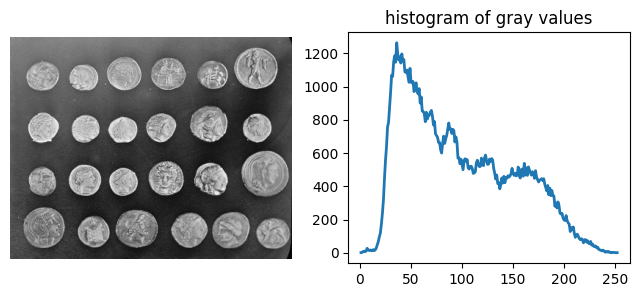

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.exposure import histogram

coins = data.coins()
hist, hist_centers = histogram(coins)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(coins, cmap=plt.cm.gray)
axes[0].axis('off')
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('histogram of gray values')

## Thresholding

A simple way to segment the coins is to choose a threshold based on the histogram of gray values. Unfortunately, thresholding this image gives a binary image that either misses significant parts of the coins or merges parts of the background with the coins:

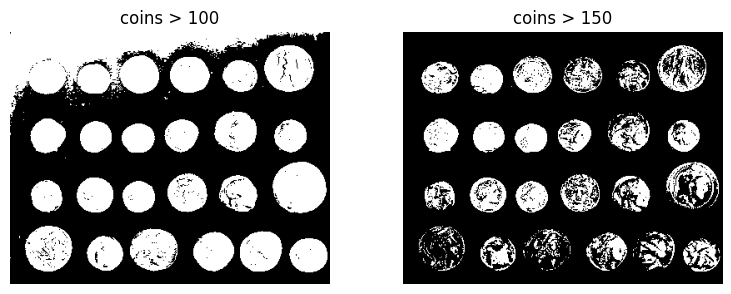

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

axes[0].imshow(coins > 100, cmap=plt.cm.gray)
axes[0].set_title('coins > 100')

axes[1].imshow(coins > 150, cmap=plt.cm.gray)
axes[1].set_title('coins > 150')

for a in axes:
    a.axis('off')

plt.tight_layout()

## Edge-based segmentation

Next, we try to delineate the contours of the coins using edge-based segmentation. To do this, we first get the edges of features using the Canny edge-detector.

(-0.5, 383.5, 302.5, -0.5)

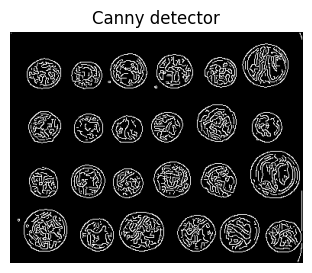

In [4]:
from skimage.feature import canny

edges = canny(coins)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(edges, cmap=plt.cm.gray)
ax.set_title('Canny detector')
ax.axis('off')

These contours are then filled using mathematical morphology.

(-0.5, 383.5, 302.5, -0.5)

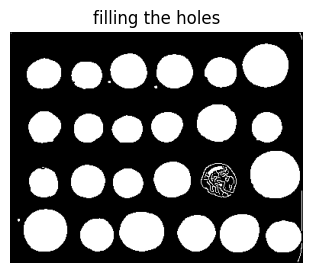

In [5]:
from scipy import ndimage as ndi

fill_coins = ndi.binary_fill_holes(edges)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(fill_coins, cmap=plt.cm.gray)
ax.set_title('filling the holes')
ax.axis('off')

Small spurious objects are easily removed by setting a minimum size for valid objects.

(-0.5, 383.5, 302.5, -0.5)

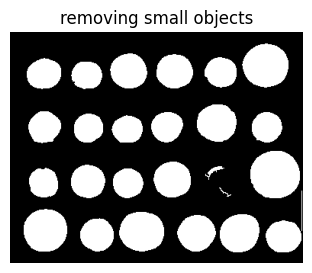

In [6]:
from skimage import morphology

coins_cleaned = morphology.remove_small_objects(fill_coins, 21)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(coins_cleaned, cmap=plt.cm.gray)
ax.set_title('removing small objects')
ax.axis('off')

However, this method is not very robust, since contours that are not perfectly closed are not filled correctly, as is the case for one unfilled coin above.

## Region-based segmentation

We therefore try a region-based method using the watershed transform. First, we find an elevation map using the Sobel gradient of the image.

(-0.5, 383.5, 302.5, -0.5)

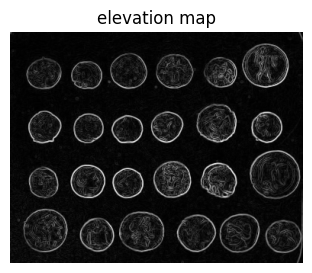

In [7]:
from skimage.filters import sobel

elevation_map = sobel(coins)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(elevation_map, cmap=plt.cm.gray)
ax.set_title('elevation map')
ax.axis('off')

Next we find markers of the background and the coins based on the extreme parts of the histogram of gray values.

(-0.5, 383.5, 302.5, -0.5)

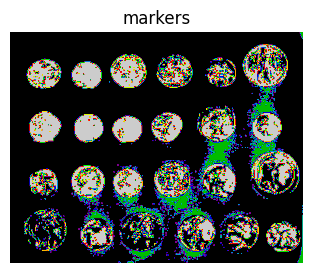

In [8]:
markers = np.zeros_like(coins)
markers[coins < 30] = 1
markers[coins > 150] = 2

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(markers, cmap=plt.cm.nipy_spectral)
ax.set_title('markers')
ax.axis('off')

Finally, we use the watershed transform to fill regions of the elevation map starting from the markers determined above:

(-0.5, 383.5, 302.5, -0.5)

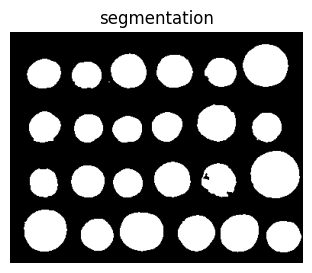

In [9]:
from skimage import segmentation

segmentation_coins = segmentation.watershed(elevation_map, markers)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(segmentation_coins, cmap=plt.cm.gray)
ax.set_title('segmentation')
ax.axis('off')

This last method works even better, and the coins can be segmented and labeled individually.

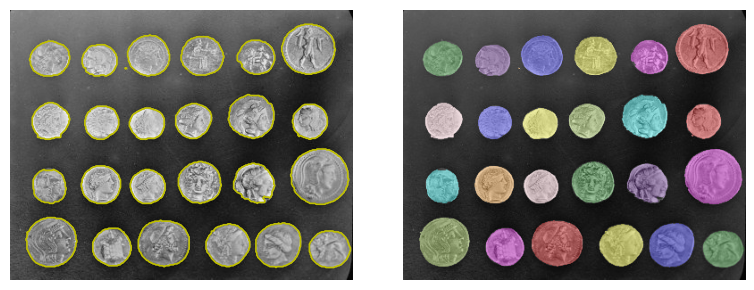

In [10]:
from skimage.color import label2rgb

segmentation_coins = ndi.binary_fill_holes(segmentation_coins - 1)
labeled_coins, _ = ndi.label(segmentation_coins)
image_label_overlay = label2rgb(labeled_coins, image=coins, bg_label=0)

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
axes[0].imshow(coins, cmap=plt.cm.gray)
axes[0].contour(segmentation_coins, [0.5], linewidths=1.2, colors='y')
axes[1].imshow(image_label_overlay)

for a in axes:
    a.axis('off')

plt.tight_layout()

plt.show()

## Acknowledgments

Thanks to [Scikit-image](https://scikit-image.org/) for creating the open-source project [Comparing edge-based and region-based segmentation](https://scikit-image.org/docs/stable/auto_examples/applications/plot_coins_segmentation.html). This inspires the majority of the content in this chapter.